### Imports

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [87]:
train_open = pd.read_csv("output_csv/train_open.csv", parse_dates = ['date'])

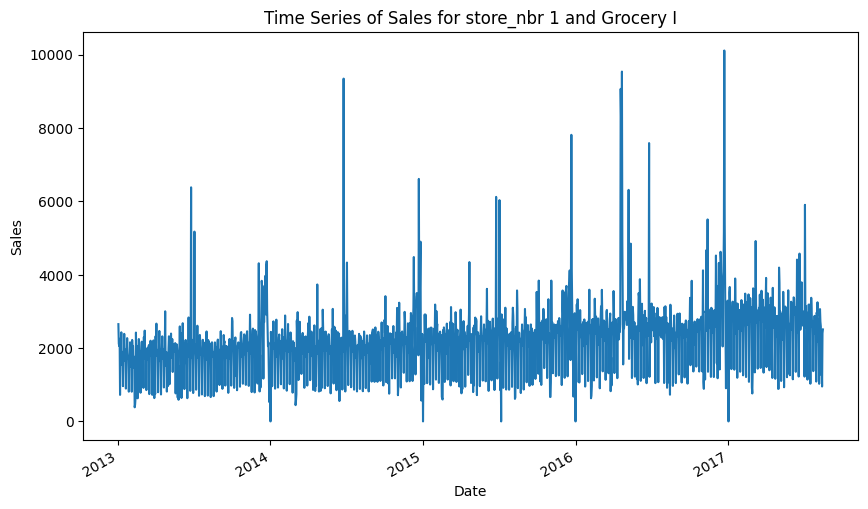

In [ ]:

ts1 = train_open[(train_open['store_nbr'] == 1) & (train_open['family'] == 12)]

#ts1 = ts1.loc[:, ("date", "sales")]
timeseries_data = ts1.groupby('date')['sales'].sum()

# Create a timeseries plot
plt.figure(figsize=(10, 6))
timeseries_data.plot()

plt.title('Time Series of Sales for store_nbr 1 and Grocery I')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [ ]:
#Creating a 3D numpy array containing sales for every store_nbr for every family for every day )

# Mporei na ginei kai me pivot table

unique_store_nbrs = np.sort(train_open['store_nbr'].unique())
unique_families = train_open['family'].unique()
unique_dates = np.sort(train_open['date'].unique())

# Initialize the 3D NumPy array with zeros
num_store_nbrs = len(unique_store_nbrs)
num_families = len(unique_families)
num_dates = len(unique_dates)
#sales_3d_array = np.zeros((num_store_nbrs, num_families, num_dates))


# Fill the 3D array with sales data
#for idx, row in train_open.iterrows():
#    store_idx = np.where(unique_store_nbrs == row['store_nbr'])[0][0]
#    family_idx = np.where(unique_families == row['family'])[0][0]
#    date_idx = np.where(unique_dates == row['date'])[0][0]
#    sales_3d_array[store_idx, family_idx, date_idx] = row['sales']

#sales_3d_array.shape

In [ ]:
#from pmdarima.arima import auto_arima

#index = pd.date_range(start='2013-01-02', periods=1683, freq='D')
#series = pd.Series(timeseries_data,index = index)
#series = series.fillna(method='ffill')   # ffill, missing sales for 25-12(Christmas) every year.

#Y = series[:1500]

#forecaster = auto_arima(Y, suppress_warnings=True)

#forecaster.fit(Y)

#Y_pred = forecaster.predict(fh=[1,2,3])

In [ ]:
#forecaster.fit(Y).summary()


In [ ]:
#define test_stationarity function to check if series is a stationary time-series

#from statsmodels.tsa.stattools import adfuller

#def test_stationarity(series):
#    result = adfuller(series)
    
#    p_value = result[1]
#    significance_level = 0.05

    # Check if the time series is stationary based on the p-value
#    if p_value <= significance_level:
#        print("The time series is stationary (Reject the null hypothesis)")
#    else:
#        print("The time series is non-stationary (Fail to reject the null hypothesis)")

#    print('ADF Statistic:', result[0])
#    print('p-value:', result[1])
#    print('Critical Values:', result[4])

# Apply the stationarity test for each family in the pivot table
#test_stationarity(series)

### Hierarchical Forecasting

In [ ]:
#Create a dataframe with 3 columns as required by StatsForecast:  unique_id, ds and y

unique_store_nbrs = np.sort(train_open['store_nbr'].unique())
unique_families = train_open['family'].unique()

# Create an empty list to store the dataframes
dfs = []

# Loop through store_nbrs and families
for store_nbr in unique_store_nbrs:
    for family in unique_families:
        # Filter the train_open DataFrame based on store_nbr and family
        filtered_df = train_open[(train_open['store_nbr'] == store_nbr) & (train_open['family'] == family)]
        
        # Create a new DataFrame for the current store_nbr and family
        new_df = pd.DataFrame({
            'ds': filtered_df['date'],
            'unique_id': store_nbr * 100 + family,  # Combine store_nbr and family as an integer
            'y': filtered_df['sales']
        })
        
        # Append the new DataFrame to the list
        dfs.append(new_df)

# Concatenate all DataFrames in the list to create the final DataFrame
new_df = pd.concat(dfs, ignore_index=True)
new_df = new_df.sort_values(by=['ds', 'unique_id'])
# Display the resulting DataFrame
print(new_df.head())
print(new_df['unique_id'].nunique())

                ds  unique_id      y
1266012 2013-01-01       2500    0.0
1267726 2013-01-01       2501    0.0
1269440 2013-01-01       2502    2.0
1271154 2013-01-01       2503  810.0
1272868 2013-01-01       2504    0.0
1782


In [ ]:

#statsforecast
from statsforecast import StatsForecast

uids = new_df['unique_id'].unique()[:99] # Select 99 ids to make the example faster (3 store_nbrs for all families)

test_df = new_df.query('unique_id in @uids') 
test_df['unique_id'].info()
#test_df = test_df.groupby('unique_id').tail()

StatsForecast.plot(test_df)

ModuleNotFoundError: No module named 'statsforecast'

In [ ]:
train_start_date = '2013-01-01'
train_end_date = '2017-07-31'
test_start_date = '2017-08-01'
test_end_date = '2017-08-15'


train_df1 = test_df[(test_df['ds'] >= train_start_date) & (test_df['ds'] <= train_end_date)]
test_df1 = test_df[(test_df['ds'] >= test_start_date) & (test_df['ds'] <= test_end_date)]


NameError: name 'test_df' is not defined

In [ ]:
# Tha sygkrinoume: train set ola kai test set 15 meres vs train set 1 year vs test set 15 meres.
#imports
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    HistoricAverage,
    SeasonalNaive
)
# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=7),
    HoltWinters(),
    HistoricAverage(),
    SeasonalNaive(season_length=7)
]


# Instantiate StatsForecast class as sf

sf = StatsForecast(
    df=train_df1,              
    models=models,
    freq='D',            
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=7)
)

forecasts_df = sf.forecast(h=15, level=[90])

forecasts_df.head()


,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,
100,2017-08-01,4.624465,0.298932,8.949997,10.0,-0.2672,20.2672,3.240283,-1.298548,7.779113,10.0,-0.2672,20.2672
100,2017-08-02,4.341013,0.012921,8.669106,2.0,-8.2672,12.2672,3.240283,-1.298548,7.779113,2.0,-8.2672,12.2672
100,2017-08-03,4.234117,-0.095413,8.563646,5.0,-5.2672,15.2672,3.240283,-1.298548,7.779113,5.0,-5.2672,15.2672
100,2017-08-04,4.884803,0.554539,9.215067,7.0,-3.2672,17.2672,3.240283,-1.298548,7.779113,7.0,-3.2672,17.2672
100,2017-08-05,4.570804,0.240363,8.901246,4.0,-6.2672,14.2672,3.240283,-1.298548,7.779113,4.0,-6.2672,14.2672


c:\Users\zygog\miniconda3\envs\data\Lib\site-packages\statsforecast\core.py:1514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unique_id"] = df["unique_id"].astype(uid_dtype)


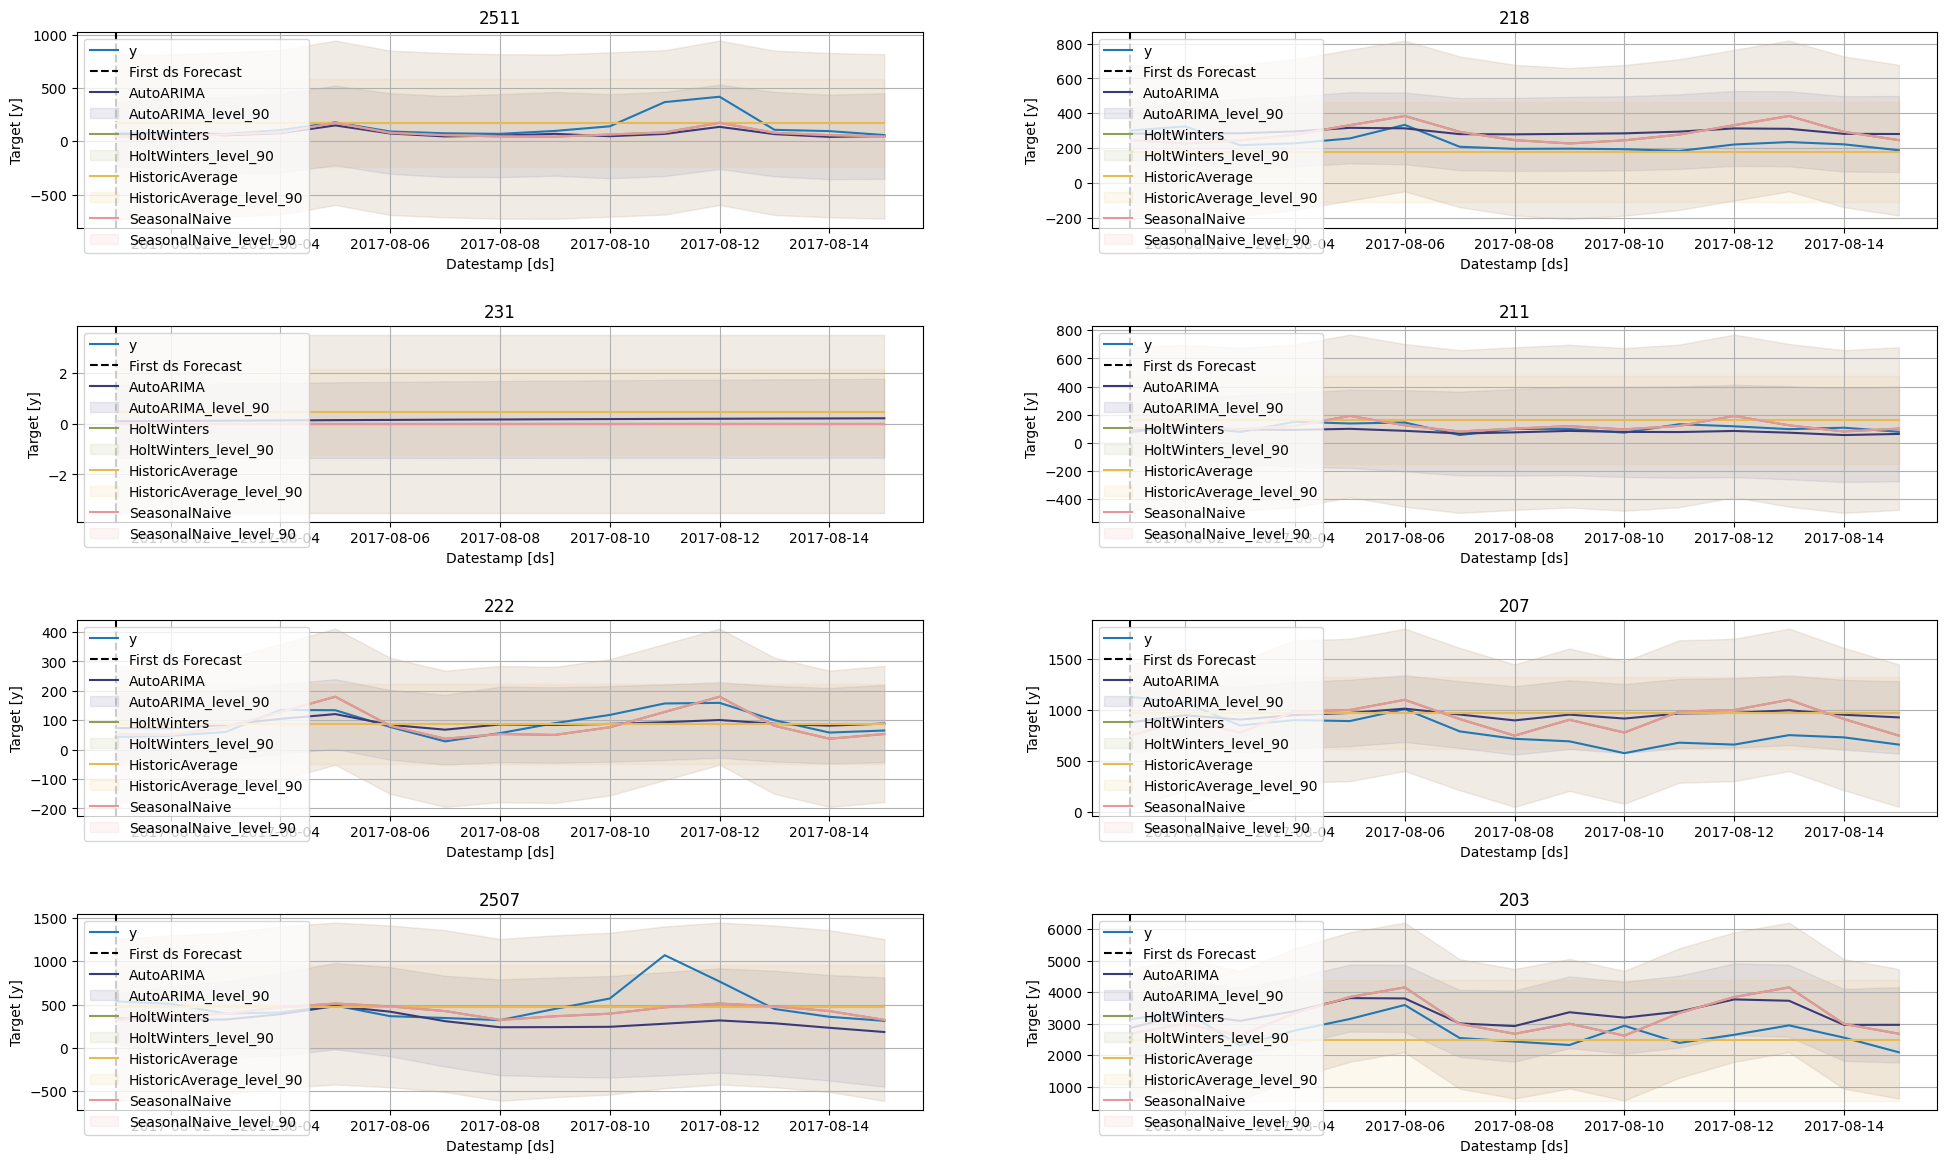

In [ ]:
sf.plot(test_df1, forecasts_df, models=["AutoARIMA","HoltWinters","HistoricAverage","SeasonalNaive"])

In [ ]:
from hierarchicalforecast.utils import aggregate


data = train_open[['date','store_nbr', 'family','sales']]
data = data.rename(columns={'date': 'ds', 'sales': 'y'})
data['Company'] = 'Top_Level'


levels = [['Company'],
        ['Company', 'store_nbr'],
        ['Company', 'store_nbr', 'family']]


data['store_nbr'] = str(data['store_nbr'])
data['family'] = str(data['family'])

#train_start_date = '2016-08-01'
#train_end_date = '2017-07-31'
#test_start_date = '2017-08-01'
#test_end_date = '2017-08-15'

train_start_date = '2015-08-01'
train_end_date = '2016-07-31'
test_start_date = '2016-08-01'
test_end_date = '2016-08-15'

train_data = data[(data['ds'] >= train_start_date) & (data['ds'] <= train_end_date)]
valid_data = data[(data['ds'] >= test_start_date) & (data['ds'] <= test_end_date)]


train_data_agg, S_train, tags = aggregate(train_data, levels)
valid_data_agg, _, _ = aggregate(valid_data, levels)


c:\Users\zygog\miniconda3\envs\test\lib\site-packages\hierarchicalforecast\utils.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unique_id'] = df[hier].agg('/'.join, axis=1)
c:\Users\zygog\miniconda3\envs\test\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\zygog\miniconda3\envs\test\lib\site-packages\hierarchicalforecast\utils.py:188: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the futu

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    HistoricAverage,
    SeasonalNaive
)
# Create a list of models and instantiation parameters
models = [
    AutoARIMA(season_length=15, alias = 'AA15'),
    AutoARIMA(season_length=7, alias = 'AA7'), 
    AutoARIMA(alias = 'AA0'),
    HoltWinters(season_length=7, error_type='A'),
    HistoricAverage(),
   # SeasonalNaive(season_length=15)
]


# Instantiate StatsForecast class as sf

sf = StatsForecast(              
    models=models,
    freq='D',            
    n_jobs=-1,
    #fallback_model = SeasonalNaive(season_length=15)
)

sf.fit(train_data_agg)



StatsForecast(models=[AA15,AA7,AA0,HoltWinters,HistoricAverage])

In [ ]:
p = sf.forecast(h=15, fitted=True)
p_fitted = sf.forecast_fitted_values()
p_fitted.head()

,ds,y,AA15,AA7,AA0,HoltWinters,HistoricAverage
unique_id,,,,,,,
Top_Level,2015-08-01,1.044895e+06,714246.5000,678377.5625,699781.3125,926290.8125,808785.625
Top_Level,2015-08-02,1.043496e+06,985259.3750,957552.5000,981047.2500,969162.8750,808785.625
Top_Level,2015-08-03,8.111198e+05,982863.4375,948237.4375,982150.5000,760812.6875,808785.625
Top_Level,2015-08-04,7.266134e+05,856288.2500,854321.9375,853277.8125,733878.9375,808785.625
Top_Level,2015-08-05,7.243466e+05,815924.0000,794902.5000,802831.2500,732581.4375,808785.625


In [ ]:
p.shape

(45, 6)

In [ ]:
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace, ERM, OptimalCombination
from hierarchicalforecast.core import HierarchicalReconciliation

reconcilers = [BottomUp(), 
               TopDown(method='forecast_proportions'),
               TopDown(method='average_proportions'),
               TopDown(method='proportion_averages'),
               MinTrace(method='ols', nonnegative=True),
               MinTrace(method='wls_struct', nonnegative=True),
               MinTrace(method='wls_var', nonnegative=True),
               MinTrace(method='mint_shrink', nonnegative=True), 
               #MinTrace(method='mint_cov', nonnegative=True),
               OptimalCombination(method='ols', nonnegative=True), 
               OptimalCombination(method='wls_struct', nonnegative=True),
               ERM(method='closed'),
               ERM(method='reg'),
               ERM(method='reg_bu'),
              ]

rec_model = HierarchicalReconciliation(reconcilers=reconcilers)

p_rec = rec_model.reconcile(Y_hat_df=p, Y_df=p_fitted, S=S_train, tags=tags)

c:\Users\zygog\miniconda3\envs\test\lib\site-packages\hierarchicalforecast\methods.py:687: UserWarning: Replacing negative forecasts with zero.
  warnings.warn('Replacing negative forecasts with zero.')
c:\Users\zygog\miniconda3\envs\test\lib\site-packages\hierarchicalforecast\methods.py:687: UserWarning: Replacing negative forecasts with zero.
  warnings.warn('Replacing negative forecasts with zero.')
c:\Users\zygog\miniconda3\envs\test\lib\site-packages\hierarchicalforecast\methods.py:687: UserWarning: Replacing negative forecasts with zero.
  warnings.warn('Replacing negative forecasts with zero.')
c:\Users\zygog\miniconda3\envs\test\lib\site-packages\hierarchicalforecast\methods.py:687: UserWarning: Replacing negative forecasts with zero.
  warnings.warn('Replacing negative forecasts with zero.')
c:\Users\zygog\miniconda3\envs\test\lib\site-packages\hierarchicalforecast\methods.py:687: UserWarning: Replacing negative forecasts with zero.
  warnings.warn('Replacing negative forecast

In [ ]:

p_rec_ = p_rec.merge(valid_data_agg, on=['ds', 'unique_id'], how='left')
#p_rec_['y'] = p_rec_['y'].fillna(0)
p_rec_ = p_rec_.reset_index(drop=False)

from sklearn.metrics import mean_squared_log_error

rmsle = dict()
for model_ in p_rec.columns[1:]:
    rmse_ = mean_squared_log_error(p_rec_['y'].values, p_rec_[model_].values, squared=False)
    # get only the model name
    model__ = model_.split('/')[-1]
    rmsle[model__] = rmse_
pd.DataFrame(rmsle, index=['RMSLE']).T.sort_values('RMSLE')


,RMSLE
AA0,0.132107
ERM_method-reg_bu_lambda_reg-0.01,0.139312
ERM_method-closed_lambda_reg-0.01,0.139312
ERM_method-reg_lambda_reg-0.01,0.139312
AA15,0.144191
TopDown_method-average_proportions,0.155707
TopDown_method-proportion_averages,0.155707
BottomUp,0.155707
TopDown_method-forecast_proportions,0.155707
MinTrace_method-ols_nonnegative-True,0.155707


In [ ]:
p_rec.head()

,ds,AA15,AA7,AA0,HoltWinters,HistoricAverage,AA15/BottomUp,AA7/BottomUp,AA0/BottomUp,HoltWinters/BottomUp,...,AA15/ERM_method-reg_lambda_reg-0.01,AA7/ERM_method-reg_lambda_reg-0.01,AA0/ERM_method-reg_lambda_reg-0.01,HoltWinters/ERM_method-reg_lambda_reg-0.01,HistoricAverage/ERM_method-reg_lambda_reg-0.01,AA15/ERM_method-reg_bu_lambda_reg-0.01,AA7/ERM_method-reg_bu_lambda_reg-0.01,AA0/ERM_method-reg_bu_lambda_reg-0.01,HoltWinters/ERM_method-reg_bu_lambda_reg-0.01,HistoricAverage/ERM_method-reg_bu_lambda_reg-0.01
unique_id,,,,,,,,,,,,,,,,,,,,,
Top_Level,2016-08-01,801879.0000,658450.6250,887898.1250,675279.6250,808785.625,801879.0000,658450.6250,887898.1250,675279.6250,...,820477.4375,670907.5000,886823.0000,663388.6250,785397.8125,820477.3750,670907.5625,886823.0000,663388.6250,785397.8125
Top_Level,2016-08-02,596487.2500,602129.7500,831378.8125,614649.3125,808785.625,596487.2500,602129.7500,831378.8125,614649.3125,...,610321.9375,613521.1875,830372.1250,603825.9375,785397.8125,610321.8750,613521.1250,830372.1250,603825.9375,785397.8125
Top_Level,2016-08-03,803742.1875,628443.8750,875711.1875,640622.3750,808785.625,803742.1875,628443.8750,875711.1875,640622.3750,...,822383.8125,640333.1250,874650.8125,629341.6250,785397.8125,822383.8125,640333.1250,874650.8125,629341.6250,785397.8125
Top_Level,2016-08-04,831053.5000,576503.3125,838274.2500,571788.6250,808785.625,831053.5000,576503.3125,838274.2500,571788.6250,...,850328.5625,587409.9375,837259.1875,561720.0000,785397.8125,850328.5625,587409.8750,837259.1875,561720.0000,785397.8125
Top_Level,2016-08-05,789619.0000,606365.0625,820023.1250,645295.4375,808785.625,789619.0000,606365.0625,820023.1250,645295.4375,...,807933.0625,617836.6250,819030.1875,633932.3750,785397.8125,807933.0625,617836.5625,819030.1875,633932.3750,785397.8125


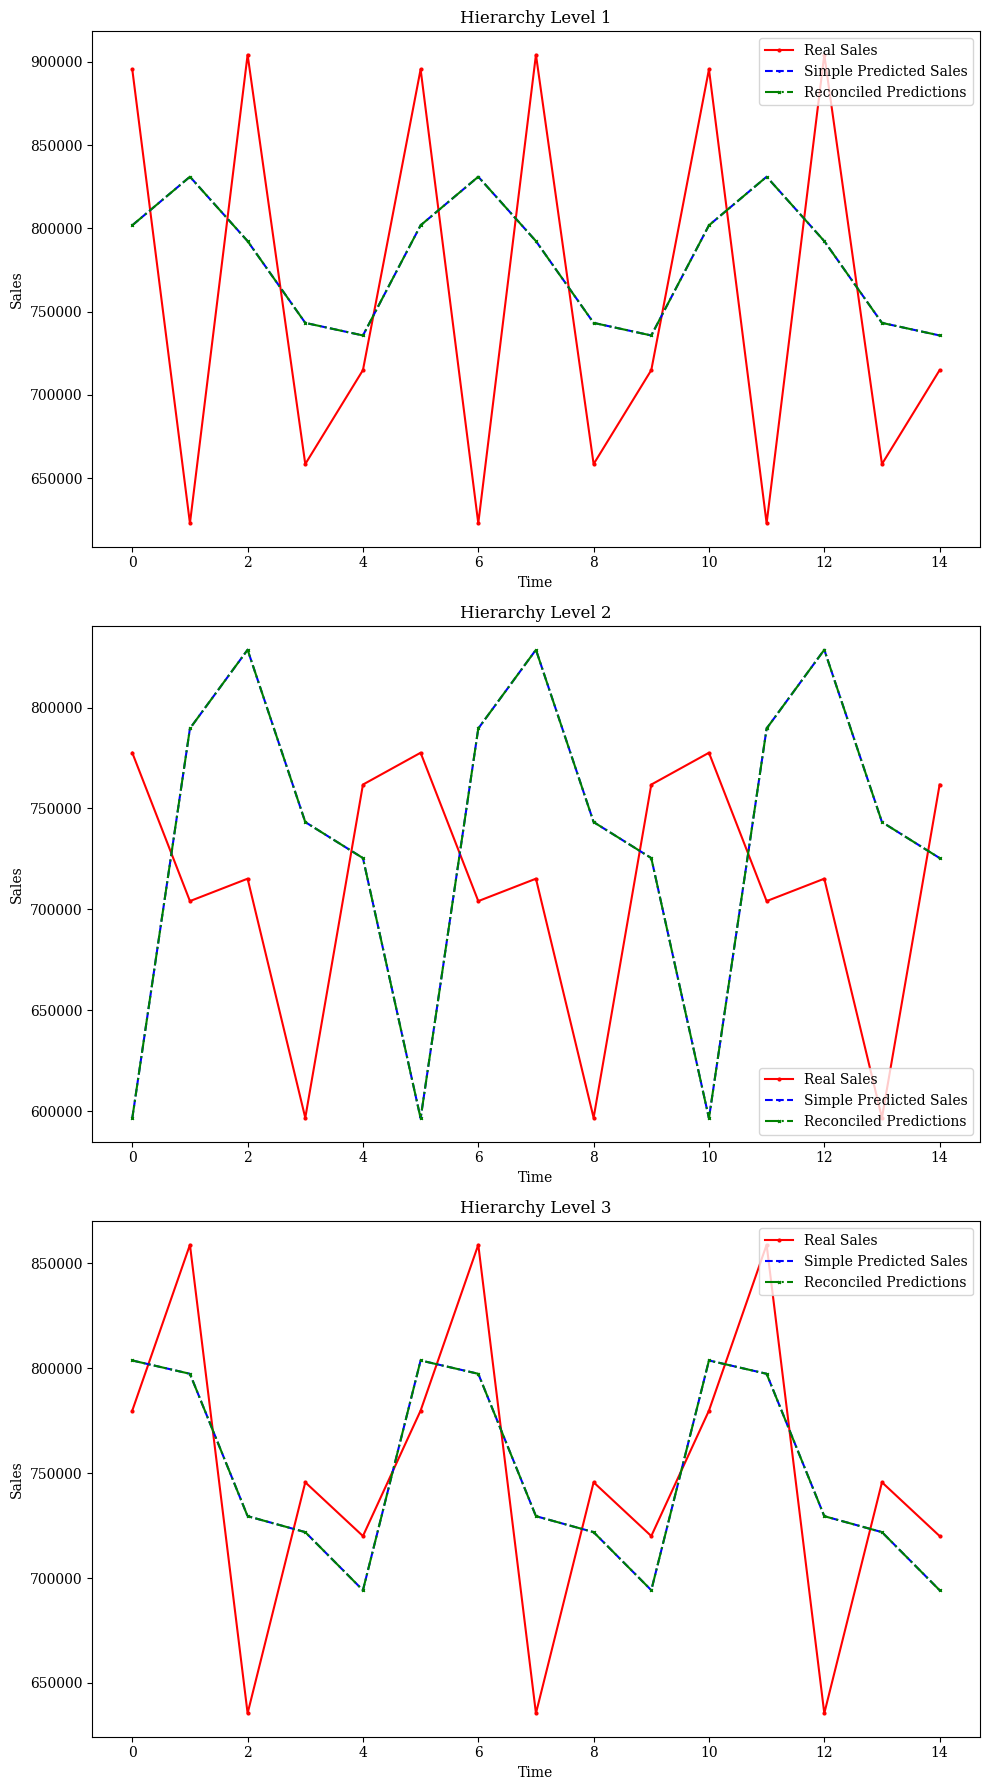

In [ ]:
model_name = 'AA15'

# Extract real sales, simple predicted sales, and reconciled predictions for the model
real_sales = valid_data_agg['y']
simple_predicted_sales = p[model_name]
reconciled_predictions = p_rec[model_name]

# Create a time series for the dates
dates = valid_data_agg['ds']

# Determine the number of hierarchy levels
num_levels = len(levels)

# Create a subplot for each hierarchy level
fig, axes = plt.subplots(num_levels, 1, figsize=(10, 6*num_levels))

# Plot each hierarchy level
for i, level in enumerate(levels):
    # Create a subplot for the current level
    ax = axes[i]
    
    # Extract the data for the current level
    real_sales_level = real_sales[i::num_levels]
    simple_predicted_sales_level = simple_predicted_sales[i::num_levels]
    reconciled_predictions_level = reconciled_predictions[i::num_levels]
    
    # Plot real sales
    ax.plot(range(len(real_sales_level)), real_sales_level, label='Real Sales', linestyle='-', marker='o', markersize=2, color='red')

    # Plot simple predicted sales
    ax.plot(range(len(real_sales_level)), simple_predicted_sales_level, label='Simple Predicted Sales', linestyle='--', marker='.', markersize=2, color='blue')

    # Plot reconciled predictions
    ax.plot(range(len(real_sales_level)), reconciled_predictions_level, label='Reconciled Predictions', linestyle='-.', marker='x', markersize=2, color='green')

    # Set labels and legend
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')
    ax.legend()
    ax.set_title(f'Hierarchy Level {i+1}')

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
valid_data['family'].nunique()

1

In [ ]:
real_sales.shape

(45,)

In [ ]:
#https://nixtla.github.io/hierarchicalforecast/


fcst = StatsForecast(df= train_data_agg, 
                     models=[
                                AutoARIMA(season_length=15, alias = 'AA15'),
                                AutoARIMA(season_length=7, alias = 'AA7'), 
                                AutoARIMA(alias = 'AA0'),
                                HoltWinters(season_length=7, error_type='A'),
                                HistoricAverage(),
                                SeasonalNaive(season_length=15, alias = 'SN15'),
                                SeasonalNaive(season_length=7, alias = 'SN7')

], 
                     freq='D', n_jobs=-1)
Y_hat_df = fcst.forecast(h=15)



In [ ]:
# Reconcile the base predictions
reconcilers = [
    BottomUp(),
    TopDown(method='forecast_proportions'),
    #MiddleOut(middle_level='Company/store_nbr',
           #   top_down_method='forecast_proportions')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=train_data_agg, 
                          S=S_train, tags=tags)

In [ ]:
# sugkrish me https://nixtla.github.io/hierarchicalforecast/. Orizetai elafrws diaforetika to evaluate , alla edw petaei errors

from hierarchicalforecast.evaluation import HierarchicalEvaluation

def rmsle(y, y_hat):
    return  mean_squared_log_error(y, y_hat, squared=False)                                        

evaluator = HierarchicalEvaluation(evaluators=[rmsle])
evaluator.evaluate(Y_rec_df, valid_data_agg, 
                   tags=tags)

,,AA15,AA7,AA0,HoltWinters,HistoricAverage,SN15,SN7,AA15/BottomUp,AA7/BottomUp,AA0/BottomUp,...,HistoricAverage/BottomUp,SN15/BottomUp,SN7/BottomUp,AA15/TopDown_method-forecast_proportions,AA7/TopDown_method-forecast_proportions,AA0/TopDown_method-forecast_proportions,HoltWinters/TopDown_method-forecast_proportions,HistoricAverage/TopDown_method-forecast_proportions,SN15/TopDown_method-forecast_proportions,SN7/TopDown_method-forecast_proportions
level,metric,,,,,,,,,,,,,,,,,,,,,
Overall,rmsle,0.11918,0.186302,0.11124,0.156496,0.133581,0.201805,0.122327,0.11918,0.186302,0.11124,...,0.133581,0.201805,0.122327,0.11918,0.186302,0.11124,0.156496,0.133581,0.201805,0.122327
Company,rmsle,0.11918,0.186302,0.11124,0.156496,0.133581,0.201805,0.122327,0.11918,0.186302,0.11124,...,0.133581,0.201805,0.122327,0.11918,0.186302,0.11124,0.156496,0.133581,0.201805,0.122327
Company/store_nbr,rmsle,0.11918,0.186302,0.11124,0.156496,0.133581,0.201805,0.122327,0.11918,0.186302,0.11124,...,0.133581,0.201805,0.122327,0.11918,0.186302,0.11124,0.156496,0.133581,0.201805,0.122327
Company/store_nbr/family,rmsle,0.11918,0.186302,0.11124,0.156496,0.133581,0.201805,0.122327,0.11918,0.186302,0.11124,...,0.133581,0.201805,0.122327,0.11918,0.186302,0.11124,0.156496,0.133581,0.201805,0.122327
